## Тип документа

Тип документа указывается в шапке документа (в верхней части документа).

В рамках задания документ может относиться к одному из следующих типов:

* «федеральный закон»
* «постановление»
* «приказ»
* «распоряжение»
* «закон»
* «указ»

Обратите внимание, что в перечне присутствуют два похожих, но отдельных типа: «закон» и «федеральный закон».

Поле type должно содержать строку, обозначающую какой-то один из указанных типов, это задача классификации.

**Оценка качества:** Требуется предсказать один из шести классов. Метрика качества – макро f1-мера.

Признаки:

* количество "федеральный", "закон", "постановление", "приказ", "распоряжение", "указ", "федеральный закон" в тексте;
* позиция, в которой встретилось каждое из этих слов;
* бинарный признак - если какое-то из слов встретилось и написано капсом;
* бинарный признак - если слово единственное в данной строке (учитываем слова из букв);
* бинарный признак - если слово первое в строке (документе);
* учет опечаток в словах??? - м. б. находить расстояние между словами (если слово написано капсом и одно в строке, то можно его сравнить со словами из нашего множества)
* можно добавить еще поиск слов "постановляет" и т. д.

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import json
import re
import numpy as np

In [2]:
reg_exprs = [
    re.compile(r'[Ф|ф]едеральный [З|з]акон'),
    re.compile(r'ФЕДЕРАЛЬНЫЙ ЗАКОН'),
    re.compile(r'[П|п]остановление'),
    re.compile(r'ПОСТАНОВЛЕНИЕ'),
    re.compile(r'[З|з]акон'),
    re.compile(r'ЗАКОН'),
    re.compile(r'[П|п]риказ'),
    re.compile(r'ПРИКАЗ'),
    re.compile(r'[Р|р]аспоряжение'),
    re.compile(r'РАСПОРЯЖЕНИЕ'),
    re.compile(r'[У|у]каз'),
    re.compile(r'УКАЗ')
]

In [3]:
TRAIN_DIR = 'train/txts/'

In [4]:
def make_features(X):
    """
    X - list of document names
    returns list of lists with document features
    """
    features = []
    for doc_name in X:
        with open(TRAIN_DIR + doc_name + '.txt', 'r') as f:
            doc = f.read()
        doc_features = [len(expr.findall(doc)) for expr in reg_exprs]
#         for expr in reg_exprs:
#             match = expr.match(doc)
#             if match:
#                 doc_features.append(match.span()[0])
#             else:
#                 doc_features.append(None)
        features.append(np.array(doc_features))
    return np.array(features)

In [5]:
classes2num = {
    'федеральный закон': 0,
    'постановление': 1,
    'приказ': 2,
    'распоряжение': 3,
    'закон': 4,
    'указ': 5
}

num2classes = {
    0: 'федеральный закон',
    1: 'постановление',
    2: 'приказ',
    3: 'распоряжение',
    4: 'закон',
    5: 'указ'
}

In [6]:
names, y = [], []
with open("train/gold_labels.txt", "r") as read_file:
    for doc_info in read_file.readlines():
        doc_dict = json.loads(doc_info)
        names.append(doc_dict['id'])
        y.append(classes2num[doc_dict['label']['type']])
names, y = np.array(names), np.array(y)

In [7]:
X = make_features(names)

In [8]:
clf = GradientBoostingClassifier()
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')

In [9]:
scores

array([0.98811521, 0.99118965, 0.98735857, 0.99559552, 0.97904905])

In [10]:
train = []
with open("train/gold_labels.txt", "r") as read_file:
    for doc_info in read_file.readlines():
        doc_dict = json.loads(doc_info)
        docname = TRAIN_DIR + doc_dict['id'] + '.txt'
        with open(docname, 'r') as f:
            train.append((f.read(), doc_dict['label']))

In [11]:
from solution import Solution
from sklearn.model_selection import train_test_split
from eval_module import quality

train_data, test = train_test_split(train)
solution = Solution()
solution.train(train_data)
test_data = [x[0] for x in test]
test_labels = [x[1] for x in test]
result = solution.predict(test_data)
quality(result, test_labels)

{'date_accuracy': 0.0,
 'number_accuracy': 0.0,
 'type_f1_score': 0.9919679402,
 'name_jaccard': 0.0,
 'authority_jaccard': 0.0,
 'subtasks_improves': 1}

[[ 55   0   0   0   0   0]
 [  0 617   0   0   0   0]
 [  0   0  22   0   0   0]
 [  0   0   0 107   0   0]
 [  0   2   0   0  33   1]
 [  0   0   0   0   0 161]]


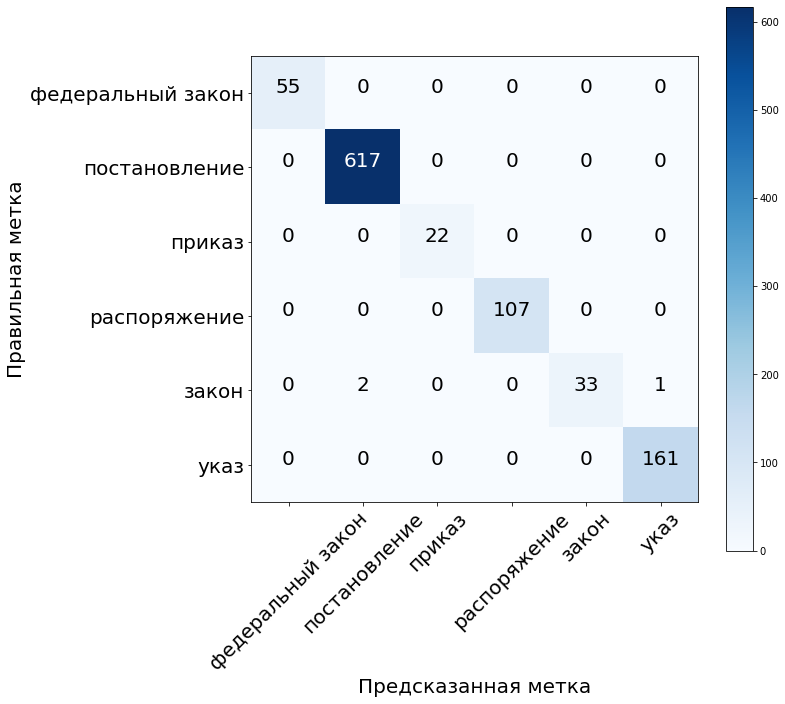

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Правильная метка', fontsize=20)
    plt.xlabel('Предсказанная метка', fontsize=20)

y_test = [x['type'] for x in test_labels]
y_pred = [x['type'] for x in result]
cnf_matrix = confusion_matrix(y_test, y_pred, labels=['федеральный закон', 'постановление', 'приказ', 
                                                      'распоряжение','закон', 'указ'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['федеральный закон', 'постановление', 'приказ', 
                                           'распоряжение','закон', 'указ'],
                      title='Confusion matrix, without normalization')

Путаем постановление и закон - в чем проблема? - в постановлениях часто встречается слово "закон"

In [13]:
i = 0
wrong_docs = []
for test, pred in zip(y_test, y_pred):
    if test != pred:
        wrong_docs.append((names[i], test, pred))
    i += 1

In [14]:
for doc_name, test, pred in wrong_docs:
    with open(TRAIN_DIR + doc_name + '.txt', 'r') as f:
        print(f"right value = {test}")
        print(f"wrong value = {pred}")
        print(f.read())
        print("=====")

right value = закон
wrong value = постановление
ЗАКОН
ЧУВАШСКОЙ РЕСПУБЛИКИ

О ВНЕСЕНИИ ИЗМЕНЕНИЙ
В СТАТЬЮ 3 ЗАКОНА ЧУВАШСКОЙ РЕСПУБЛИКИ
"О МУНИЦИПАЛЬНОМ ЖИЛИЩНОМ КОНТРОЛЕ
И ВЗАИМОДЕЙСТВИИ ОРГАНА ГОСУДАРСТВЕННОГО
ЖИЛИЩНОГО НАДЗОРА ЧУВАШСКОЙ РЕСПУБЛИКИ
С ОРГАНАМИ МУНИЦИПАЛЬНОГО
ЖИЛИЩНОГО КОНТРОЛЯ"

Принят
Государственным Советом
Чувашской Республики
19 декабря 2014 года

Статья 1

Внести в статью 3 Закона Чувашской Республики от 3 октября
2012 года № 58 "О муниципальном жилищном контроле и взаимодействии
органа государственного жилищного надзора Чувашской Республики с органами муниципального жилищного контроля" (газета "Республика", 2012,
5 октября; Собрание законодательства Чувашской Республики, 2014, № 2)
следующие изменения:

1) часть 1 изложить в следующей редакции:

"]. Органы - местного самоуправления муниципального района,
городского поселения и городского округа организовывают муниципальный жилищный контроль соответственно на территории сельских поселений, городского поселения, г